In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 52.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
    

In [2]:
!pip install nvidia-pyindex nvidia-cuda-runtime-cu12 nvidia-cudnn-cu12

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8419 sha256=ef0d3a5c8b517a92fb1ec72b1523d68bd925077b2305a3fb0e5660675897aa9b
  Stored in directory: /root/.cache/pip/wheels/49/d0/7d/b68b3665d16ee20355e65fb7ef48b7ca26533217d9f09924fe
Successfully built nvidia-pyindex


In [ ]:
# =========================
# IMPORTS
# =========================
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split




2026-01-06 16:07:21.806187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-06 16:07:21.806241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-06 16:07:21.807831: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [11]:
class ImageDataGenerator:
    def __init__(
        self,
        rotation_range=0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        shear_range=0.0,
        zoom_range=0.0,
        horizontal_flip=False,
        fill_mode='nearest'
    ):
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip

    def _augment(self, image):
        image = tf.convert_to_tensor(image, dtype=tf.float32)

        if self.horizontal_flip:
            image = tf.image.random_flip_left_right(image)

        if self.zoom_range > 0:
            scale = tf.random.uniform([], 1 - self.zoom_range, 1.0)
            h, w = tf.shape(image)[0], tf.shape(image)[1]
            new_h = tf.cast(scale * tf.cast(h, tf.float32), tf.int32)
            new_w = tf.cast(scale * tf.cast(w, tf.float32), tf.int32)
            image = tf.image.random_crop(image, [new_h, new_w, 3])
            image = tf.image.resize(image, [h, w])

        return tf.clip_by_value(image, 0, 255)

    def flow(self, image_tensor, batch_size=1):
        class Iterator:
            def __init__(self, parent, img):
                self.parent = parent
                self.img = img

            def next(self):
                aug = self.parent._augment(self.img)
                return np.expand_dims(aug.numpy().astype("uint8"), axis=0)

        return Iterator(self, image_tensor[0])


In [12]:
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, d, f), "label": label}
        for label, d in enumerate(os.listdir(data_dir))
        for f in os.listdir(os.path.join(data_dir, d))
    ]
    return pd.DataFrame(data)

def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).convert("RGB").resize((128, 128)))

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='val')
    ax1.set_title("Accuracy")
    ax1.legend()
    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='val')
    ax2.set_title("Loss")
    ax2.legend()
    plt.show()


In [9]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    return heatmap.numpy()


In [13]:

train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'
max_images_per_class = 2000

df = pd.concat([create_dataframe(train_dir), create_dataframe(test_dir)], ignore_index=True)
label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}
num_classes = len(label_map)

df = df.groupby("label").head(max_images_per_class).reset_index(drop=True)

with concurrent.futures.ThreadPoolExecutor() as executor:
    df['image'] = list(executor.map(resize_image_array, df['image_path']))

datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.5,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True
)

augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for class_label in df['label'].unique():
    class_images = df[df['label'] == class_label]
    image_arrays = class_images['image'].values
    augmented_df = pd.concat([augmented_df, class_images], ignore_index=True)

    num_needed = max_images_per_class - len(image_arrays)
    if num_needed > 0:
        selected = np.random.choice(image_arrays, size=num_needed, replace=True)
        for img in selected:
            image_tensor = np.expand_dims(img, axis=0)
            aug = datagen.flow(image_tensor).next()[0]
            augmented_df = pd.concat([
                augmented_df,
                pd.DataFrame([{'image_path': None, 'label': class_label, 'image': aug}])
            ], ignore_index=True)

df = augmented_df.groupby('label').head(max_images_per_class).sample(frac=1).reset_index(drop=True)


In [14]:
X = np.asarray(df['image'].tolist())
y = to_categorical(df['label'], num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_mean, X_std = X_train.mean(), X_train.std()
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std


In [15]:
!nvidia-smi


Tue Jan  6 16:13:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [16]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())

TF version: 2.15.0
Built with CUDA: True


In [17]:
#import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth enabled")
    except RuntimeError as e:
        print("RuntimeError:", e)


GPUs found: []


In [ ]:
model = Sequential([
    DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_validate, y_validate),
    callbacks=[learning_rate_reduction]
)

In [ ]:
model.save('/kaggle/working/skin_disease_model.h5')

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

y_proba = model.predict(X_test)   # shape: (n_samples, 9)
y_pred = np.argmax(y_proba, axis=1)

if len(y_test.shape) > 1 and y_test.shape[1] == 9:
    y_true = np.argmax(y_test, axis=1)
else:
    y_true = y_test

accuracy = accuracy_score(y_true, y_pred)

precision = precision_score(
    y_true,
    y_pred,
    average="macro",
    zero_division=0
)

recall = recall_score(
    y_true,
    y_pred,
    average="macro"
)

f1 = f1_score(
    y_true,
    y_pred,
    average="macro"
)

auc = roc_auc_score(
    y_true,
    y_proba,
    multi_class="ovr",
    average="macro"
)


loss, acc_eval = model.evaluate(X_test, y_test, verbose=0)

# 
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Accuracy (Keras eval): {acc_eval:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"AUC (macro OVR): {auc:.4f}")


113/113 [==============================] - 82s 723ms/step
Loss: 0.2657
Accuracy: 0.8997
Accuracy (Keras eval): 0.8997
Recall (macro): 0.8992
F1 Score (macro): 0.8985
Precision (macro): 0.9012
AUC (macro OVR): 0.9906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


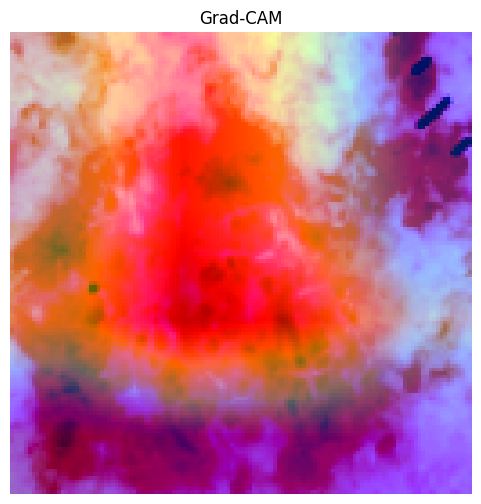

In [25]:
last_conv_layer_name = "conv5_block32_2_conv"

img = X_test[0]
img_input = np.expand_dims(img, axis=0)

heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
heatmap = tf.image.resize(heatmap[..., None], (128, 128)).numpy().squeeze()

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.title("Grad-CAM")
plt.axis('off')
plt.show()


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def show_gradcam_grid(
    model,
    X,
    y,
    label_map,
    last_conv_layer_name,
    num_images=6,
    seed=42
):
    """
    Side-by-side Original vs Grad-CAM
    """
    np.random.seed(seed)
    indices = np.random.choice(len(X), num_images, replace=False)

    plt.figure(figsize=(10, 4 * num_images))

    for i, idx in enumerate(indices):
        img = X[idx]
        img_input = np.expand_dims(img, axis=0)

        # Prediction
        preds = model.predict(img_input, verbose=0)
        pred_class = np.argmax(preds[0])
        true_class = np.argmax(y[idx])

        # Grad-CAM
        heatmap = make_gradcam_heatmap(
            img_input,
            model,
            last_conv_layer_name
        )

        heatmap = tf.image.resize(
            heatmap[..., None],
            img.shape[:2]
        ).numpy().squeeze()

        # ---- Original ----
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(
            f"Original\nTrue: {label_map[true_class]}\nPred: {label_map[pred_class]}",
            fontsize=10
        )
        plt.axis("off")

        # ---- Grad-CAM ----
        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(img)
        plt.imshow(heatmap, cmap="jet", alpha=0.45)
        plt.title("Grad-CAM", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

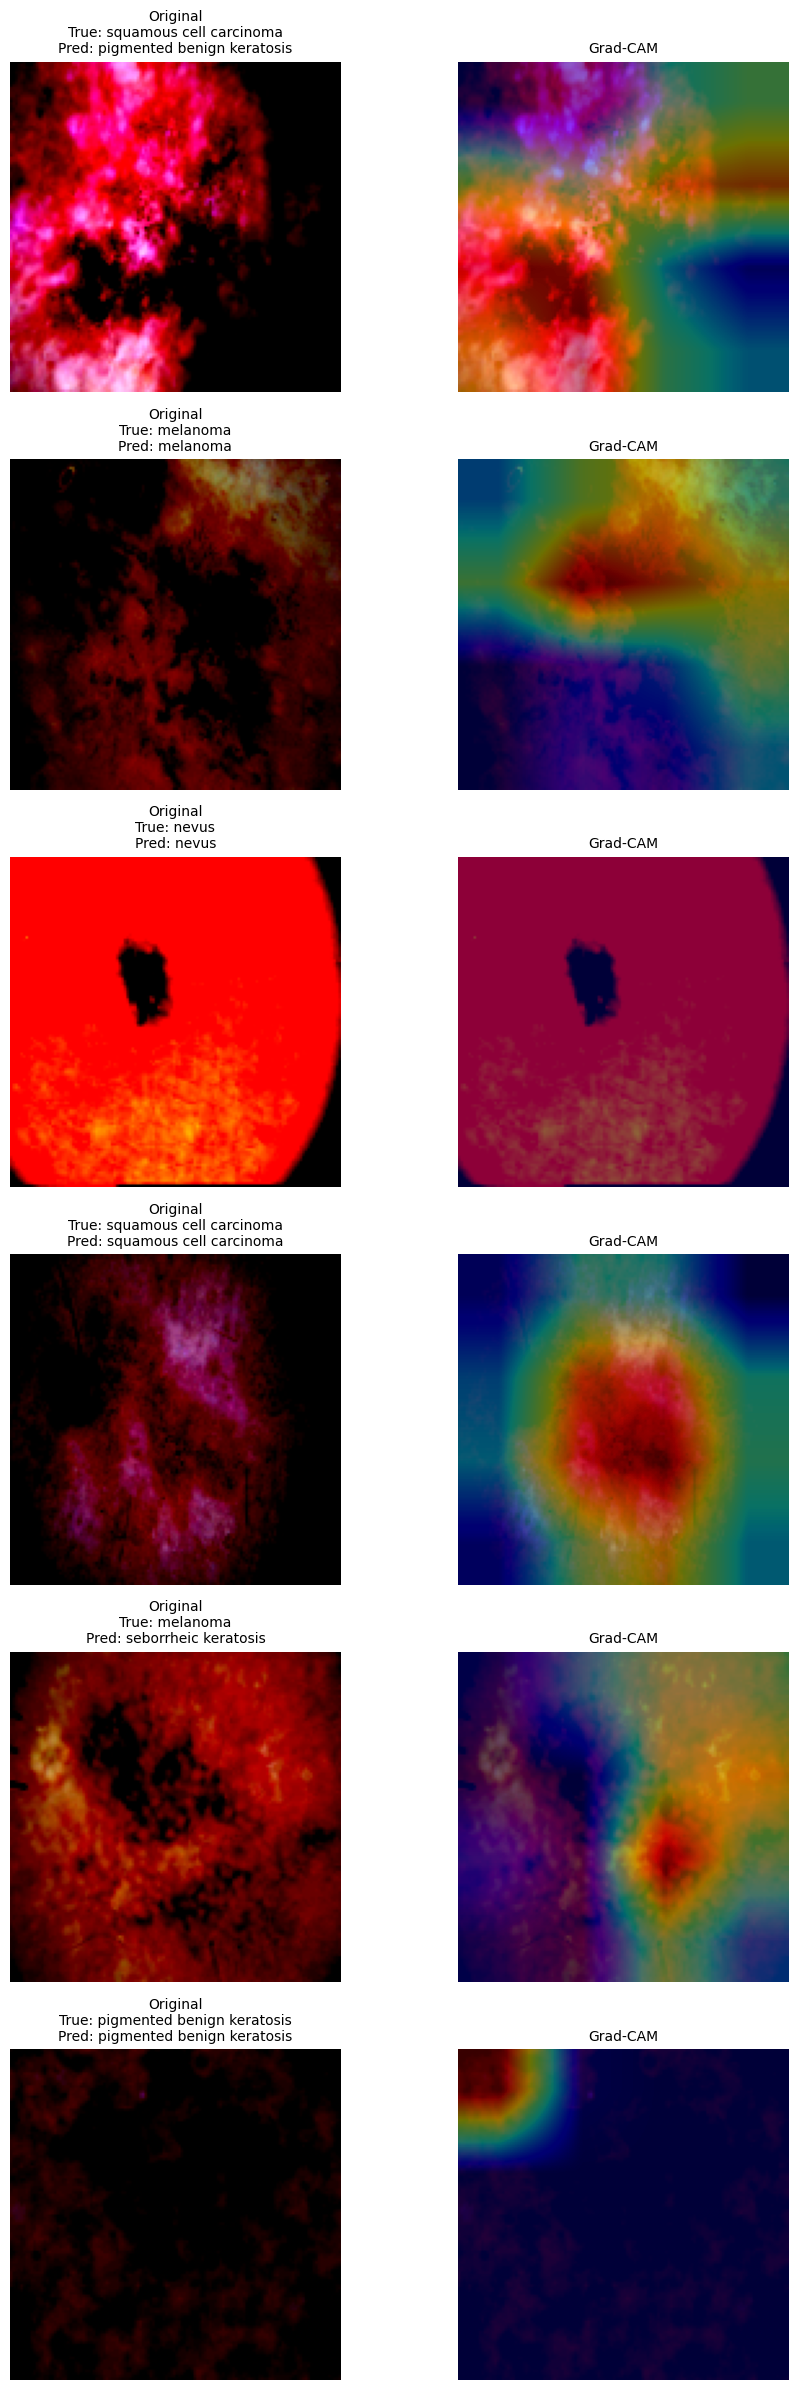

In [27]:
show_gradcam_grid(
    model=model,
    X=X_test,
    y=y_test,
    label_map=label_map,
    last_conv_layer_name="conv5_block32_2_conv",
    num_images=6
)

In [28]:
model.save("/kaggle/working/model.keras")
print("Done")

Done


In [29]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explain_with_lime(model, image, label_map, num_samples=1000):
    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
        image.astype(np.double),
        classifier_fn=lambda x: model.predict(x),
        top_labels=1,
        hide_color=0,
        num_samples=num_samples
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME: {label_map[top_label]}")
    plt.axis("off")

    plt.show()



Explaining test image index: 2129


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 298ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


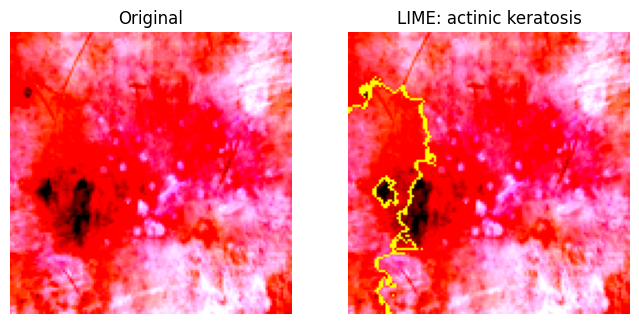


Explaining test image index: 786


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 290ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


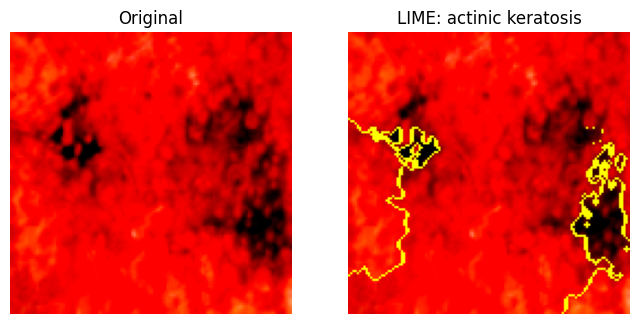


Explaining test image index: 2164


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 288ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


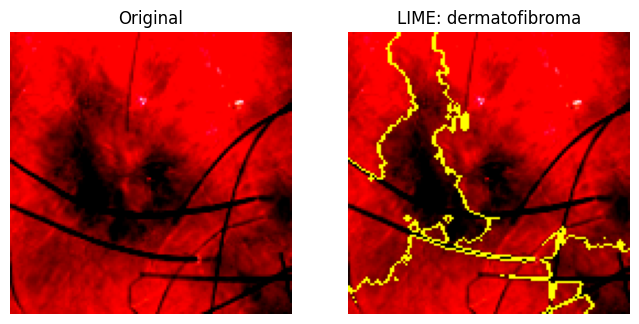


Explaining test image index: 1607


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 287ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


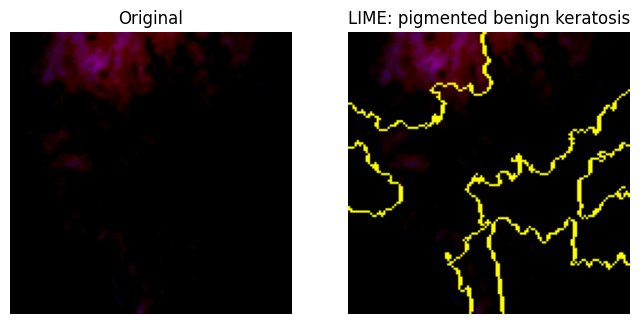


Explaining test image index: 2926


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 292ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


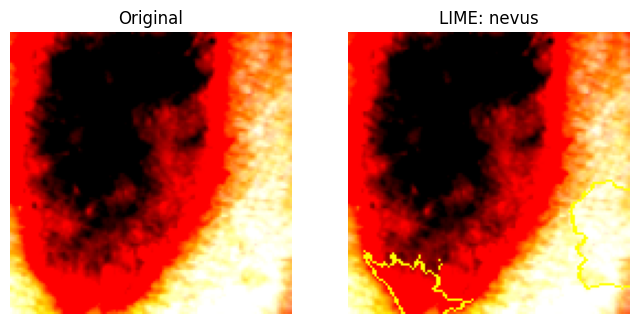

In [30]:
num_images = 5  # how many explanations you want

indices = np.random.choice(len(X_test), num_images, replace=False)

for idx in indices:
    print(f"\nExplaining test image index: {idx}")
    explain_with_lime(
        model,
        X_test[idx],
        label_map
    )


In [31]:
if not hasattr(tf.keras.backend, "learning_phase"):
    tf.keras.backend.learning_phase = lambda: False
import shap

# Background samples (VERY IMPORTANT: keep small)
background = X_train[np.random.choice(X_train.shape[0], 50, replace=False)]

explainer = shap.GradientExplainer(
    model,
    background
)


In [32]:
# Background samples (keep this SMALL)
background = X_train[
    np.random.choice(X_train.shape[0], 30, replace=False)
]
explainer = shap.GradientExplainer(
    model,
    background
)


In [33]:
test_samples = X_test[:3]  # explain first 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


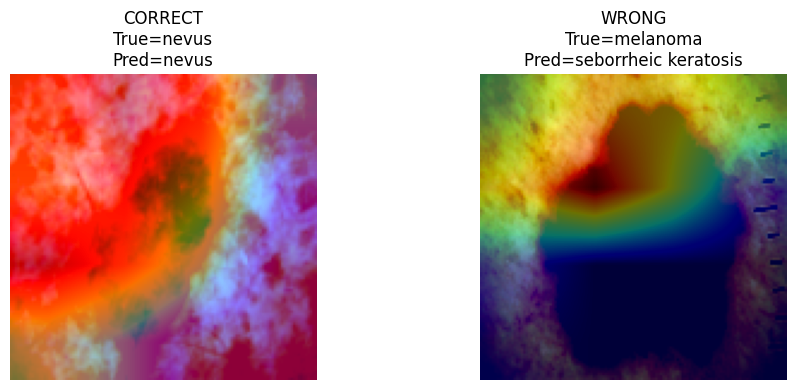

In [34]:
import numpy as np
import matplotlib.pyplot as plt

preds = model.predict(X_test, verbose=0)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)

correct_idx = np.where(y_true == y_pred)[0]
wrong_idx = np.where(y_true != y_pred)[0]

# pick one of each
idx_correct = np.random.choice(correct_idx)
idx_wrong = np.random.choice(wrong_idx)

def show_gradcam_pair(idx, title):
    img = X_test[idx]
    heatmap = make_gradcam_heatmap(
        img[None], model, "conv5_block32_2_conv"
    )
    heatmap = tf.image.resize(
        heatmap[..., None], img.shape[:2]
    ).numpy().squeeze()

    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.45)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
show_gradcam_pair(
    idx_correct,
    f"CORRECT\nTrue={label_map[y_true[idx_correct]]}\nPred={label_map[y_pred[idx_correct]]}"
)

plt.subplot(1,2,2)
show_gradcam_pair(
    idx_wrong,
    f"WRONG\nTrue={label_map[y_true[idx_wrong]]}\nPred={label_map[y_pred[idx_wrong]]}"
)

plt.tight_layout()
plt.show()


In [35]:
# example mapping — ADJUST to your dataset
benign_classes = ["nevus", "seborrheic_keratosis"]
malignant_classes = ["melanoma"]

benign_ids = [k for k,v in label_map.items() if v in benign_classes]
malignant_ids = [k for k,v in label_map.items() if v in malignant_classes]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


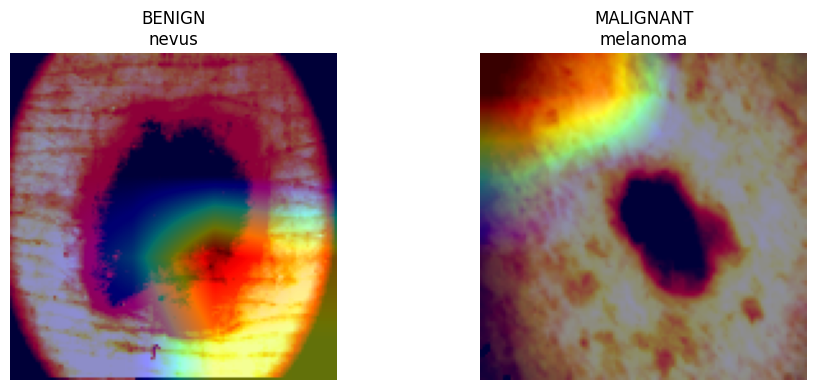

In [36]:
benign_idx = np.where(np.isin(y_true, benign_ids))[0]
malignant_idx = np.where(np.isin(y_true, malignant_ids))[0]

idx_b = np.random.choice(benign_idx)
idx_m = np.random.choice(malignant_idx)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
show_gradcam_pair(
    idx_b,
    f"BENIGN\n{label_map[y_true[idx_b]]}"
)

plt.subplot(1,2,2)
show_gradcam_pair(
    idx_m,
    f"MALIGNANT\n{label_map[y_true[idx_m]]}"
)

plt.tight_layout()
plt.show()


In [38]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def gradcam_and_lime(idx):
    img = X_test[idx]

    # ---- Grad-CAM ----
    heatmap = make_gradcam_heatmap(
        img[None], model, "conv5_block32_2_conv"
    )
    heatmap = tf.image.resize(
        heatmap[..., None], img.shape[:2]
    ).numpy().squeeze()

    # ---- LIME ----
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img.astype(np.double),
        classifier_fn=lambda x: model.predict(x),
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    top_label = explanation.top_labels[0]
    lime_img, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(img)
    plt.imshow(heatmap, cmap="jet", alpha=0.45)
    plt.title("Grad-CAM")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(mark_boundaries(lime_img, mask))
    plt.title("LIME")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 288ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


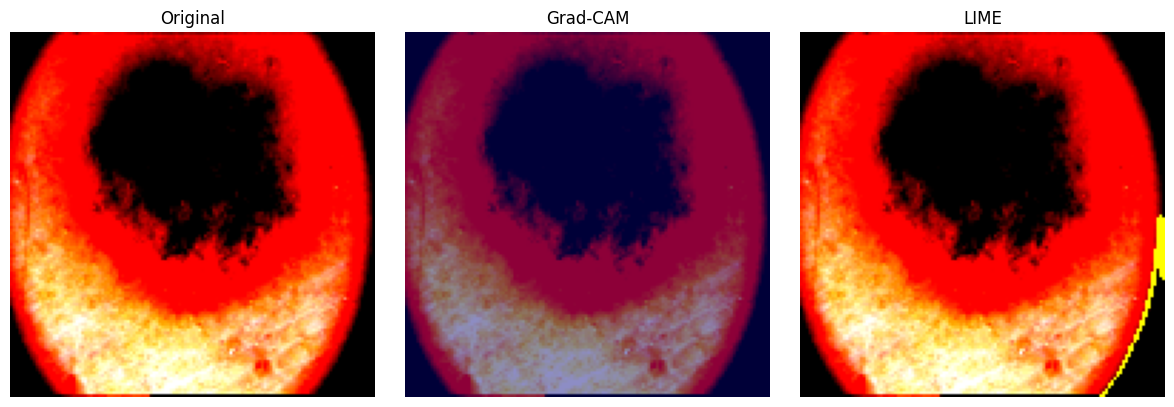

In [39]:
idx = np.random.randint(0, len(X_test))
gradcam_and_lime(idx)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 290ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


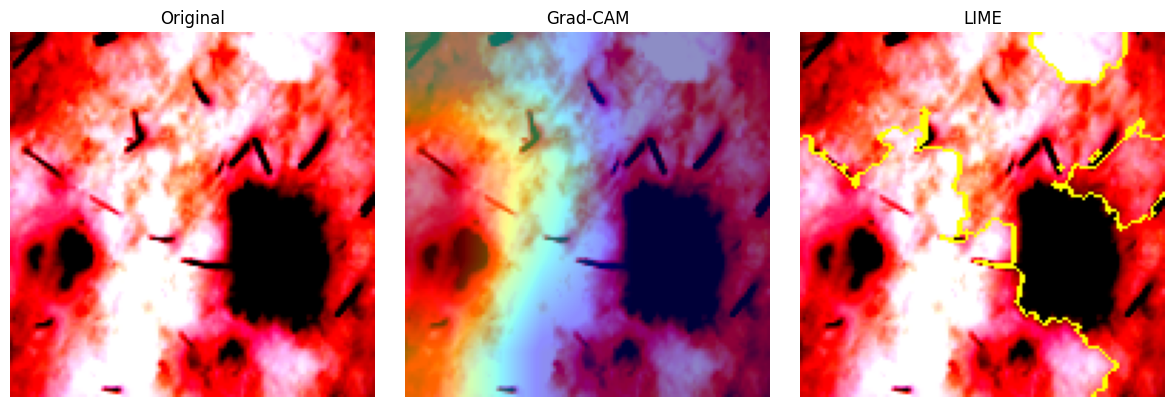

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 288ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


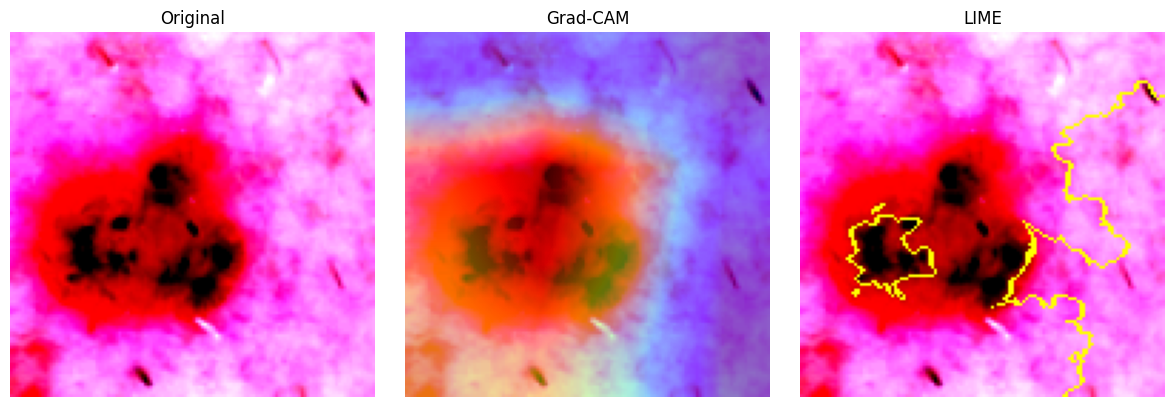

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 287ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


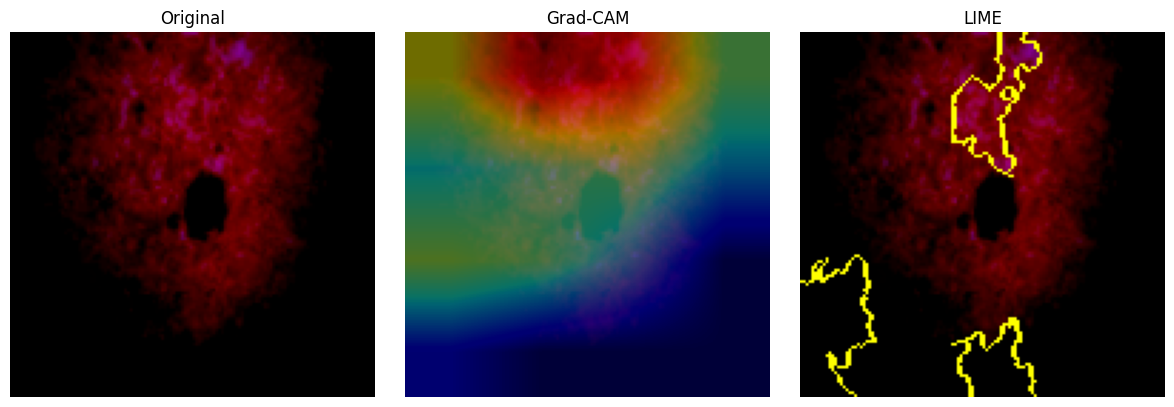

In [40]:
num_images = 3  # how many explanations you want

indices = np.random.choice(len(X_test), num_images, replace=False)

for idx in indices:
    gradcam_and_lime(idx)